In [22]:
import os, cv2, glob, random
import numpy                     as np
import tensorflow                as tf
import matplotlib.pyplot         as plt
from keras.callbacks         import EarlyStopping
from sklearn.model_selection import train_test_split

print("Num TPUs Available: ", len(tf.config.list_physical_devices('TPU')))
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))
print("Num CPUs Available: ", len(tf.config.list_physical_devices('CPU')))

Num TPUs Available:  0
Num GPUs Available:  0
Num CPUs Available:  1


In [36]:
# DATASET_PATH = "./datasets/ds_v2"
# DATASET_PATH_TEST_IMAGE = "./datasets/ds_v2/A/mpoetza1.pgm"
DATASET_PATH = "./datasets/ds_v4/All_Nums"
DATASET_PATH_TEST_IMAGE = "./datasets/ds_v4/All_Nums/3/0c3ff922-7744-40e5-8fe9-10dcbc5dca3c.rgb_0000.png"

# MODEL_PATH = "./models/model_v2.keras"
MODEL_PATH = "./models/model_v4.keras"

# QUANTIZED_MODEL_PATH = "./models/quant_model_v2.tflite"
QUANTIZED_MODEL_PATH = "./models/quant_model_v4.tflite"

# HEX_MODEL_PATH = "./models/hex_model_v2.cc"
HEX_MODEL_PATH = "./models/hex_model_v4.cc"

# LIST_OF_GESTURES = ['A', 'B', "Blank", "Five", "One", "Three", "Two"] # ds_v2
LIST_OF_GESTURES = ['1', "10", '2', '3', '4', '5', "Blank"] # ds_v4

Para colab

In [24]:
# from google.colab import drive
# drive.mount('/content/drive')

# %cp -r "/content/drive/MyDrive/datasets/dataset_v4.1.zip" "dataset_v4.1.zip"
# %unzip "content/drive/MyDrive/datasets/dataset_v4.1.zip" -d .
# %clear && ls

# DATASET_PATH = './dataset_v4.1'

# MODELO DE REGRESIÓN LINEAL

## Pre procesamiento

Final dataset:
* Dataset 1: https://www.idiap.ch/webarchives/sites/www.idiap.ch/resource/gestures/ (finalmente no se uso)
* Dataset 2: https://www.kaggle.com/datasets/lexset/synthetic-asl-numbers

In [25]:
dataset_path = os.path.join(DATASET_PATH, '*')
dataset_path = glob.glob(dataset_path)
dataset_path

['./datasets/ds_v4/All_Nums/Blank',
 './datasets/ds_v4/All_Nums/10',
 './datasets/ds_v4/All_Nums/1',
 './datasets/ds_v4/All_Nums/5',
 './datasets/ds_v4/All_Nums/2',
 './datasets/ds_v4/All_Nums/3',
 './datasets/ds_v4/All_Nums/4']

Verificar el dataset

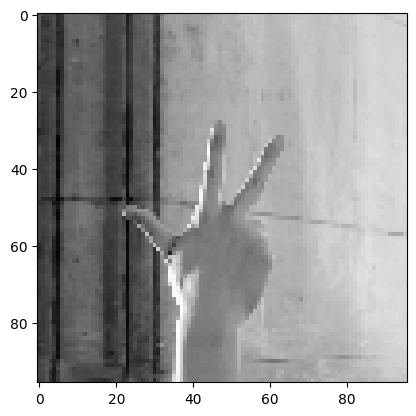

In [26]:
image = cv2.imread(DATASET_PATH_TEST_IMAGE)
image = cv2.resize(image,(96, 96))
image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
plt.imshow(image, cmap='gray')

Pre procesamiento

In [27]:
datagen = tf.keras.preprocessing.image.ImageDataGenerator(
    rotation_range=10,
    width_shift_range=0.2,
    height_shift_range=0.2,
    zoom_range=0.05,
    horizontal_flip=True,
    fill_mode='nearest'
)

def apply_augmentation(X_train, y_train, augmentation_fraction=0.5):
    num_images = int(len(X_train) * augmentation_fraction)
    random_indices = random.sample(range(len(X_train)), num_images)

    augmented_images = []
    augmented_labels = []

    for index in random_indices:
        image = X_train[index].reshape((1, 96, 96, 1))
        label = y_train[index]

        for aug_image in datagen.flow(image, batch_size=1):
            augmented_images.append(aug_image[0])
            augmented_labels.append(label)
            break

    X_augmented = np.asarray(augmented_images)
    y_augmented = np.asarray(augmented_labels)

    X_train_augmented = np.concatenate((X_train, X_augmented), axis=0)
    y_train_augmented = np.concatenate((y_train, y_augmented), axis=0)

    return X_train_augmented, y_train_augmented

In [28]:
loaded_images = []
outputVectors = []

for gesture_index, gesture in enumerate(LIST_OF_GESTURES):
    dataset_path = f"{DATASET_PATH}/{gesture}"
    gesture_path = os.path.join(dataset_path, '*')
    gest_path = glob.glob(gesture_path)

    for image_path in gest_path:
        image = cv2.imread(image_path)
        if image is not None:
            gray_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
            gray_image = cv2.resize(gray_image, (96, 96))
            loaded_images.append(gray_image)
            outputVector = [0] * len(LIST_OF_GESTURES)
            outputVector[gesture_index] = 1
            outputVectors.append(outputVector)

print(f"Número total de imágenes cargadas: {len(loaded_images)}")
print(f"Número total de vectores de salida: {len(outputVectors)}\n")

X = np.asarray(loaded_images)
y = np.asarray(outputVectors)
print(f"Forma de X: {X.shape}")
print(f"Forma de y: {y.shape}\n")

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=4)
X_train = X_train.reshape(X_train.shape[0], 96, 96, 1)
X_test = X_test.reshape(X_test.shape[0], 96, 96, 1)

print(f"Forma de X_train: {X_train.shape}")
print(f"Forma de X_test: {X_test.shape}")
print(f"Forma de y_train: {y_train.shape}")
print(f"Forma de y_test: {y_test.shape}\n")

X_train_augmented, y_train_augmented = apply_augmentation(X_train, y_train, augmentation_fraction=0.5)
X_test_augmented, y_test_augmented = apply_augmentation(X_test, y_test, augmentation_fraction=0.5)

print(f"Forma de X_train después de augmentation: {X_train_augmented.shape}")
print(f"Forma de y_train después de augmentation: {y_train_augmented.shape}")
print(f"Forma de X_test después de augmentation: {X_test_augmented.shape}")
print(f"Forma de y_test después de augmentation: {y_test_augmented.shape}")

Número total de imágenes cargadas: 7000
Número total de vectores de salida: 7000

Forma de X: (7000, 96, 96)
Forma de y: (7000, 7)

Forma de X_train: (5600, 96, 96, 1)
Forma de X_test: (1400, 96, 96, 1)
Forma de y_train: (5600, 7)
Forma de y_test: (1400, 7)

Forma de X_train después de augmentation: (8400, 96, 96, 1)
Forma de y_train después de augmentation: (8400, 7)
Forma de X_test después de augmentation: (2100, 96, 96, 1)
Forma de y_test después de augmentation: (2100, 7)


## CNN MODEL

In [29]:
model = tf.keras.Sequential([
    # tf.keras.layers.InputLayer(input_shape=(96, 96, 1)),
    tf.keras.layers.Conv2D(filters=32, kernel_size=(3, 3), activation='relu', input_shape=(96, 96, 1)),
    tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),
    tf.keras.layers.Dropout(0.05),
    tf.keras.layers.Conv2D(filters=64, kernel_size=(3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),
    tf.keras.layers.Dropout(0.05),
    tf.keras.layers.Conv2D(filters=64, kernel_size=(3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),
    tf.keras.layers.Dropout(0.05),
    tf.keras.layers.Conv2D(filters=96, kernel_size=(3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),
    tf.keras.layers.Dropout(0.05),
    tf.keras.layers.Conv2D(filters=96, kernel_size=(3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),
    tf.keras.layers.Dropout(0.05),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(384, activation='relu'),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dropout(0.1),
    tf.keras.layers.Dense(192, activation='relu'),
    tf.keras.layers.Dropout(0.1),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dropout(0.05),
    tf.keras.layers.Dense(32, activation='relu'),
    tf.keras.layers.Dense(7, activation='softmax')
])

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
model.summary()

/home/benja/Documents/University_studies/Proyecto_de_Desarrollo_de_Software_ICC4201/pds3/model_preparation/venv/lib/python3.12/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_5 (Conv2D)               │ (None, 94, 94, 32)     │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 47, 47, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_9 (Dropout)             │ (None, 47, 47, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_6 (Conv2D)               │ (None, 45, 45, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_6 (MaxPooling2D)  │ (None, 22, 22, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_10 (Dropout)            │ (None, 22, 22, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_7 (Conv2D)               │ (None, 20, 20, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_7 (MaxPooling2D)  │ (None, 10, 10, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_11 (Dropout)            │ (None, 10, 10, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_8 (Conv2D)               │ (None, 8, 8, 96)       │        55,392 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_8 (MaxPooling2D)  │ (None, 4, 4, 96)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_12 (Dropout)            │ (None, 4, 4, 96)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_9 (Conv2D)               │ (None, 2, 2, 96)       │        83,040 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_9 (MaxPooling2D)  │ (None, 1, 1, 96)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_13 (Dropout)            │ (None, 1, 1, 96)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 96)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 384)            │        37,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_14 (Dropout)            │ (None, 384)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 64)             │        24,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_15 (Dropout)            │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 192)            │        12,480 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_16 (Dropout)            │ (None, 192)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ (None, 64)             │        12,352 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_17 (Dropout)            │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_10 (Dense)                │ (None, 32)             │         2,08

 Total params: 283,207 (1.08 MB)

 Trainable params: 283,207 (1.08 MB)

 Non-trainable params: 0 (0.00 B)

## Entrenamiento

In [30]:
early_stopping_callback = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

history = model.fit(X_train_augmented, y_train_augmented,
          batch_size=128,
          epochs=200,
          verbose=1,
          validation_data=(X_test, y_test),
          callbacks=[early_stopping_callback])

Epoch 1/200
66/66 ━━━━━━━━━━━━━━━━━━━━ 18s 249ms/step - accuracy: 0.1495 - loss: 0.4704 - val_accuracy: 0.1657 - val_loss: 0.4379
Epoch 2/200
66/66 ━━━━━━━━━━━━━━━━━━━━ 16s 242ms/step - accuracy: 0.1594 - loss: 0.4171 - val_accuracy: 0.2529 - val_loss: 0.3982
Epoch 3/200
66/66 ━━━━━━━━━━━━━━━━━━━━ 17s 260ms/step - accuracy: 0.2446 - loss: 0.3946 - val_accuracy: 0.3814 - val_loss: 0.3265
Epoch 4/200
66/66 ━━━━━━━━━━━━━━━━━━━━ 17s 264ms/step - accuracy: 0.4065 - loss: 0.3275 - val_accuracy: 0.6700 - val_loss: 0.2191
Epoch 5/200
66/66 ━━━━━━━━━━━━━━━━━━━━ 17s 259ms/step - accuracy: 0.5876 - loss: 0.2472 - val_accuracy: 0.8114 - val_loss: 0.1395
Epoch 6/200
66/66 ━━━━━━━━━━━━━━━━━━━━ 17s 259ms/step - accuracy: 0.7113 - loss: 0.1918 - val_accuracy: 0.8800 - val_loss: 0.0896
Epoch 7/200
66/66 ━━━━━━━━━━━━━━━━━━━━ 17s 263ms/step - accuracy: 0.8127 - loss: 0.1297 - val_accuracy: 0.9021 - val_loss: 0.0775
Epoch 8/200
66/66 ━━━━━━━━━━━━━━━━━━━━ 17s 258ms/step - accuracy: 0.8413 - loss: 0.1133 - 

Guardar

In [31]:
model.save(MODEL_PATH)

## Información

Evaluar el modelo

In [32]:
[loss, acc] = model.evaluate(X_test,y_test,verbose=1)
print("Accuracy: " + str(acc))
model.summary()

44/44 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - accuracy: 0.9644 - loss: 0.0336
Accuracy: 0.9671428799629211


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_5 (Conv2D)               │ (None, 94, 94, 32)     │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 47, 47, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_9 (Dropout)             │ (None, 47, 47, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_6 (Conv2D)               │ (None, 45, 45, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_6 (MaxPooling2D)  │ (None, 22, 22, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_10 (Dropout)            │ (None, 22, 22, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_7 (Conv2D)               │ (None, 20, 20, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_7 (MaxPooling2D)  │ (None, 10, 10, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_11 (Dropout)            │ (None, 10, 10, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_8 (Conv2D)               │ (None, 8, 8, 96)       │        55,392 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_8 (MaxPooling2D)  │ (None, 4, 4, 96)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_12 (Dropout)            │ (None, 4, 4, 96)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_9 (Conv2D)               │ (None, 2, 2, 96)       │        83,040 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_9 (MaxPooling2D)  │ (None, 1, 1, 96)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_13 (Dropout)            │ (None, 1, 1, 96)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 96)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 384)            │        37,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_14 (Dropout)            │ (None, 384)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 64)             │        24,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_15 (Dropout)            │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 192)            │        12,480 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_16 (Dropout)            │ (None, 192)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ (None, 64)             │        12,352 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_17 (Dropout)            │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_10 (Dense)                │ (None, 32)             │         2,08

 Total params: 849,623 (3.24 MB)

 Trainable params: 283,207 (1.08 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 566,416 (2.16 MB)

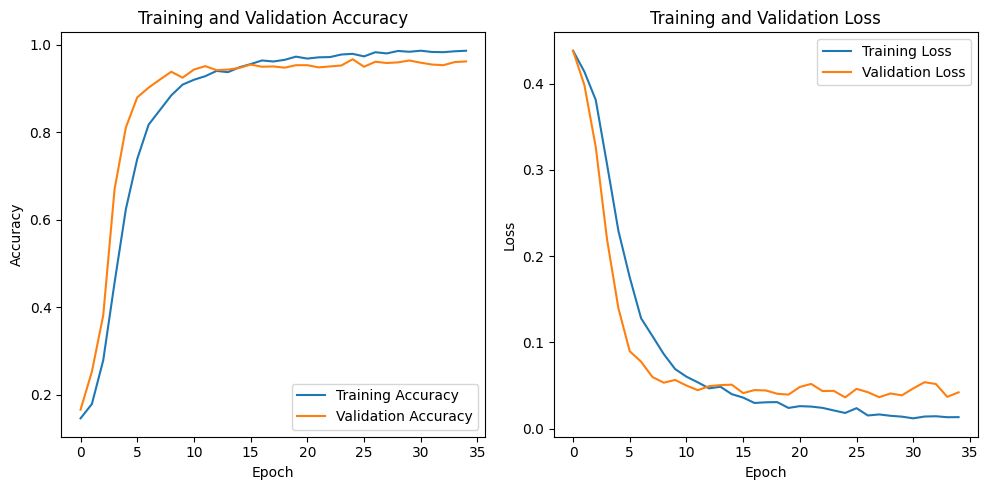

In [33]:
def plot_accuracy_loss(history):

    fig = plt.figure(figsize=(10, 5))

    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Training Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title('Training and Validation Accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Training and Validation Loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend()

    plt.tight_layout()
    plt.show()

plot_accuracy_loss(history)

## Predicciones del modelo

In [34]:
[loss, acc] = model.evaluate(X_test,y_test,verbose=1)
print("Accuracy: " + str(acc))
print("Testing Accuracy:", acc)

44/44 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - accuracy: 0.9644 - loss: 0.0336
Accuracy: 0.9671428799629211
Testing Accuracy: 0.9671428799629211


44/44 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step


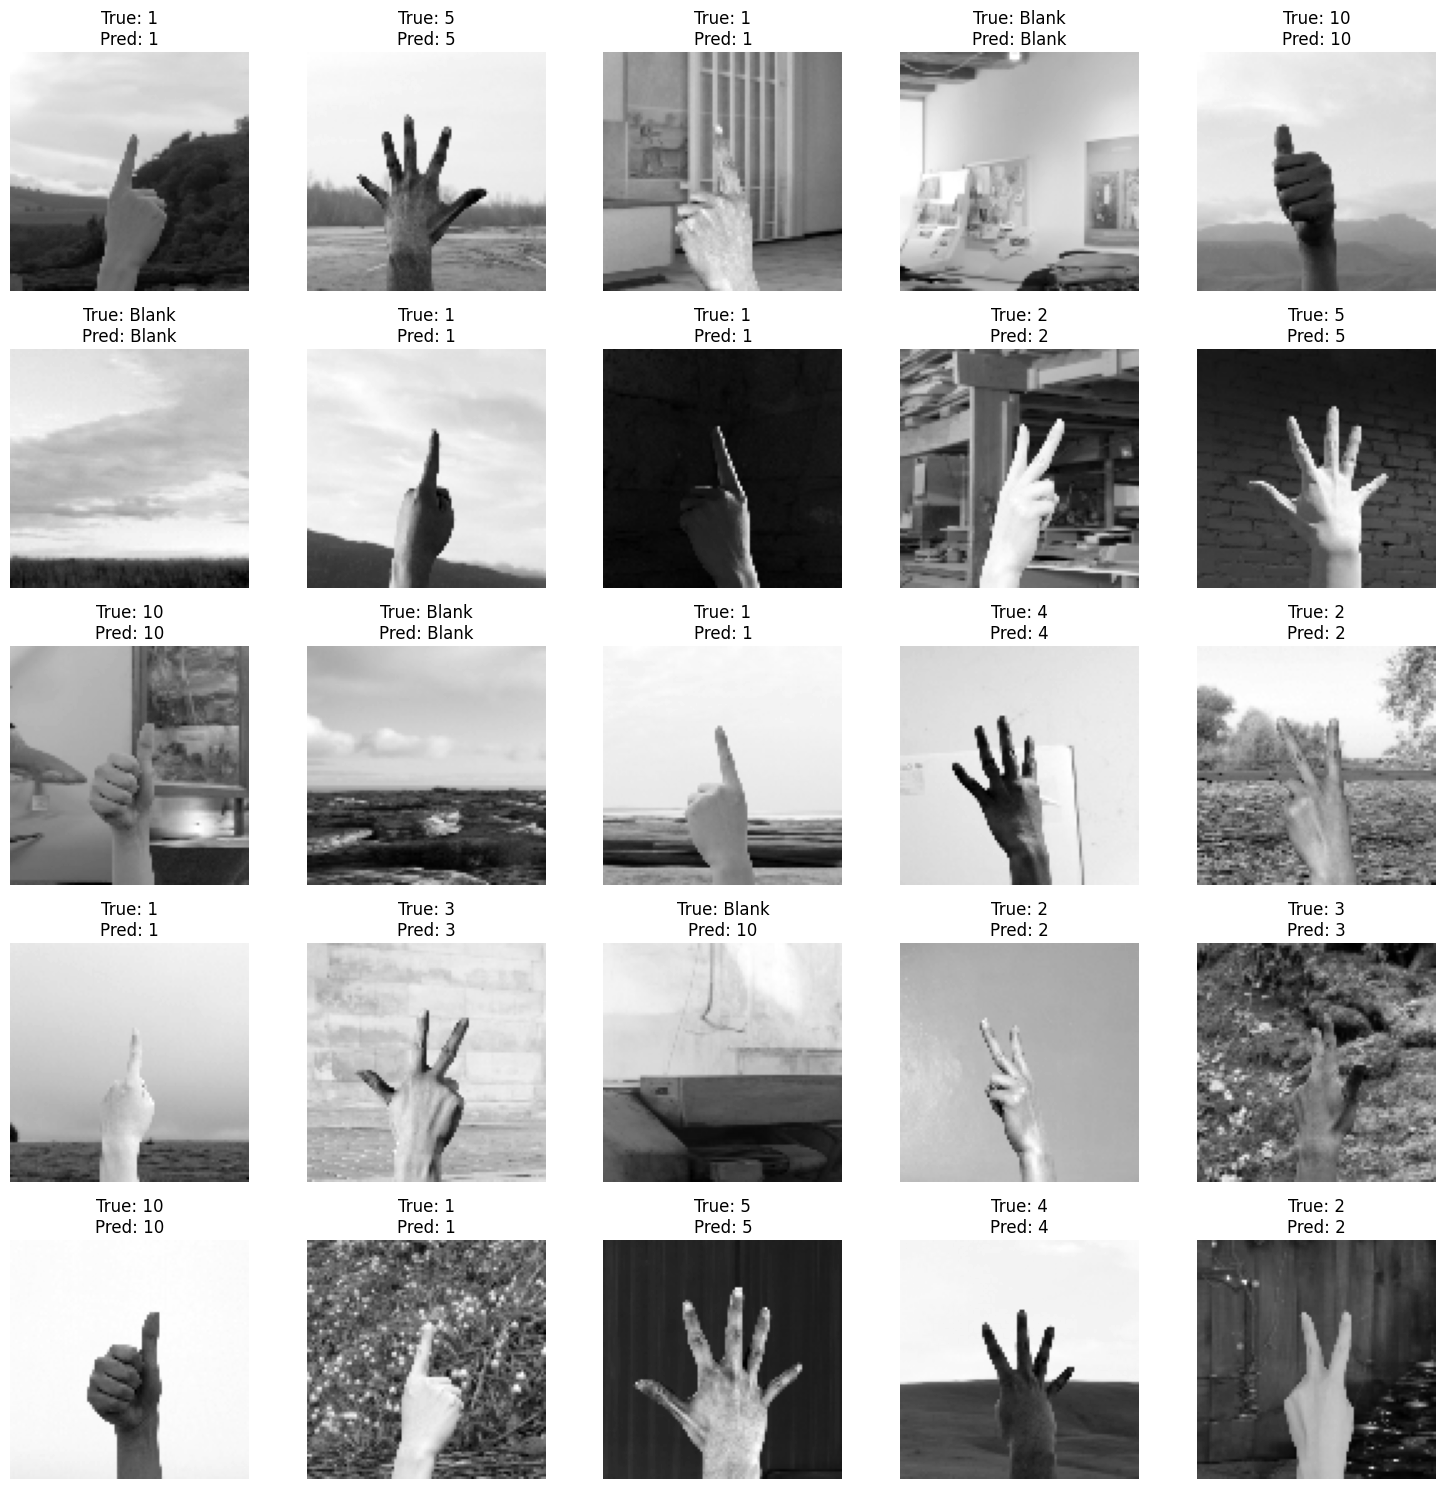

In [37]:
y_pred = model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true_classes = np.argmax(y_test, axis=1)

num_images_to_display = 25
plt.figure(figsize=(15, 15))

for i in range(num_images_to_display):
  plt.subplot(5, 5, i + 1)
  plt.imshow(X_test[i].reshape(96, 96), cmap='gray')
  plt.title(f"True: {LIST_OF_GESTURES[y_true_classes[i]]}\nPred: {LIST_OF_GESTURES[y_pred_classes[i]]}")
  plt.axis('off')

plt.tight_layout()
plt.show()

# CUANTIZACIÓN

In [38]:
model = tf.keras.models.load_model(MODEL_PATH)

converter = tf.lite.TFLiteConverter.from_keras_model(model)
converter._experimental_disable_per_channel_quantization_for_dense_layers = True

converter.optimizations = [tf.lite.Optimize.DEFAULT]

def representative_dataset():
    for i in range(len(X_train_augmented)):
        image = X_train_augmented[i].reshape(1, 96, 96, 1)
        yield [image.astype(np.float32)]

converter.representative_dataset = representative_dataset

converter.target_spec.supported_ops = [tf.lite.OpsSet.TFLITE_BUILTINS_INT8]
converter.inference_input_type = tf.uint8
converter.inference_output_type = tf.uint8

quantized_tflite_model = converter.convert()

with open(QUANTIZED_MODEL_PATH, 'wb') as f: f.write(quantized_tflite_model)
print(f"Modelo cuantizado guardado exitosamente como '{QUANTIZED_MODEL_PATH}'.")

INFO:tensorflow:Assets written to: /tmp/tmpu6z3vo14/assets


INFO:tensorflow:Assets written to: /tmp/tmpu6z3vo14/assets


Saved artifact at '/tmp/tmpu6z3vo14'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 96, 96, 1), dtype=tf.float32, name='input_layer_1')
Output Type:
  TensorSpec(shape=(None, 7), dtype=tf.float32, name=None)
Captures:
  127087827880464: TensorSpec(shape=(), dtype=tf.resource, name=None)
  127087827880656: TensorSpec(shape=(), dtype=tf.resource, name=None)
  127087848477648: TensorSpec(shape=(), dtype=tf.resource, name=None)
  127087848474576: TensorSpec(shape=(), dtype=tf.resource, name=None)
  127087848477072: TensorSpec(shape=(), dtype=tf.resource, name=None)
  127087859463376: TensorSpec(shape=(), dtype=tf.resource, name=None)
  127087858991760: TensorSpec(shape=(), dtype=tf.resource, name=None)
  127087858992720: TensorSpec(shape=(), dtype=tf.resource, name=None)
  127087858998480: TensorSpec(shape=(), dtype=tf.resource, name=None)
  127087869826960: TensorSpec(shape=(), dtype=tf.resource, name=None)
  127087880555600

/home/benja/Documents/University_studies/Proyecto_de_Desarrollo_de_Software_ICC4201/pds3/model_preparation/venv/lib/python3.12/site-packages/tensorflow/lite/python/convert.py:983: UserWarning: Statistics for quantized inputs were expected, but not specified; continuing anyway.
  warnings.warn(
W0000 00:00:1729553228.202414  422913 tf_tfl_flatbuffer_helpers.cc:392] Ignored output_format.
W0000 00:00:1729553228.202445  422913 tf_tfl_flatbuffer_helpers.cc:395] Ignored drop_control_dependency.
2024-10-21 20:27:08.202742: I tensorflow/cc/saved_model/reader.cc:83] Reading SavedModel from: /tmp/tmpu6z3vo14
2024-10-21 20:27:08.203609: I tensorflow/cc/saved_model/reader.cc:52] Reading meta graph with tags { serve }
2024-10-21 20:27:08.203622: I tensorflow/cc/saved_model/reader.cc:147] Reading SavedModel debug info (if present) from: /tmp/tmpu6z3vo14
2024-10-21 20:27:08.211996: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:388] MLIR V1 optimization pass is not enabled
2024-10-21 20:

Modelo cuantizado guardado exitosamente como './models/quant_model_v4.tflite'.


fully_quantize: 0, inference_type: 6, input_inference_type: UINT8, output_inference_type: UINT8


In [39]:
interpreter = tf.lite.Interpreter(model_path=QUANTIZED_MODEL_PATH)
interpreter.allocate_tensors()

input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()

def preprocess_image(image):
    image = image.astype(np.uint8)
    image = image.reshape(1, 96, 96, 1)
    return image

def evaluate_model(interpreter, test_images, test_labels):
    total_seen = 0
    num_correct = 0

    for i in range(len(test_images)):
        input_data = preprocess_image(test_images[i])
        interpreter.set_tensor(input_details[0]['index'], input_data)
        interpreter.invoke()
        output_data = interpreter.get_tensor(output_details[0]['index'])
        predicted_label = np.argmax(output_data)
        if predicted_label == np.argmax(test_labels[i]): num_correct += 1
        total_seen += 1

    accuracy = num_correct / total_seen
    print(f"Precisión del modelo cuantizado: {accuracy:.4f}")

evaluate_model(interpreter, X_test, y_test)

model_size = os.path.getsize(QUANTIZED_MODEL_PATH)
print(f"Tamaño del modelo cuantizado: {model_size / 1024:.2f} KB")  # Mostrar en kilobytes

INFO: Created TensorFlow Lite XNNPACK delegate for CPU.


Precisión del modelo cuantizado: 0.9664
Tamaño del modelo cuantizado: 296.28 KB


## Predicciones del modelo cuantizado

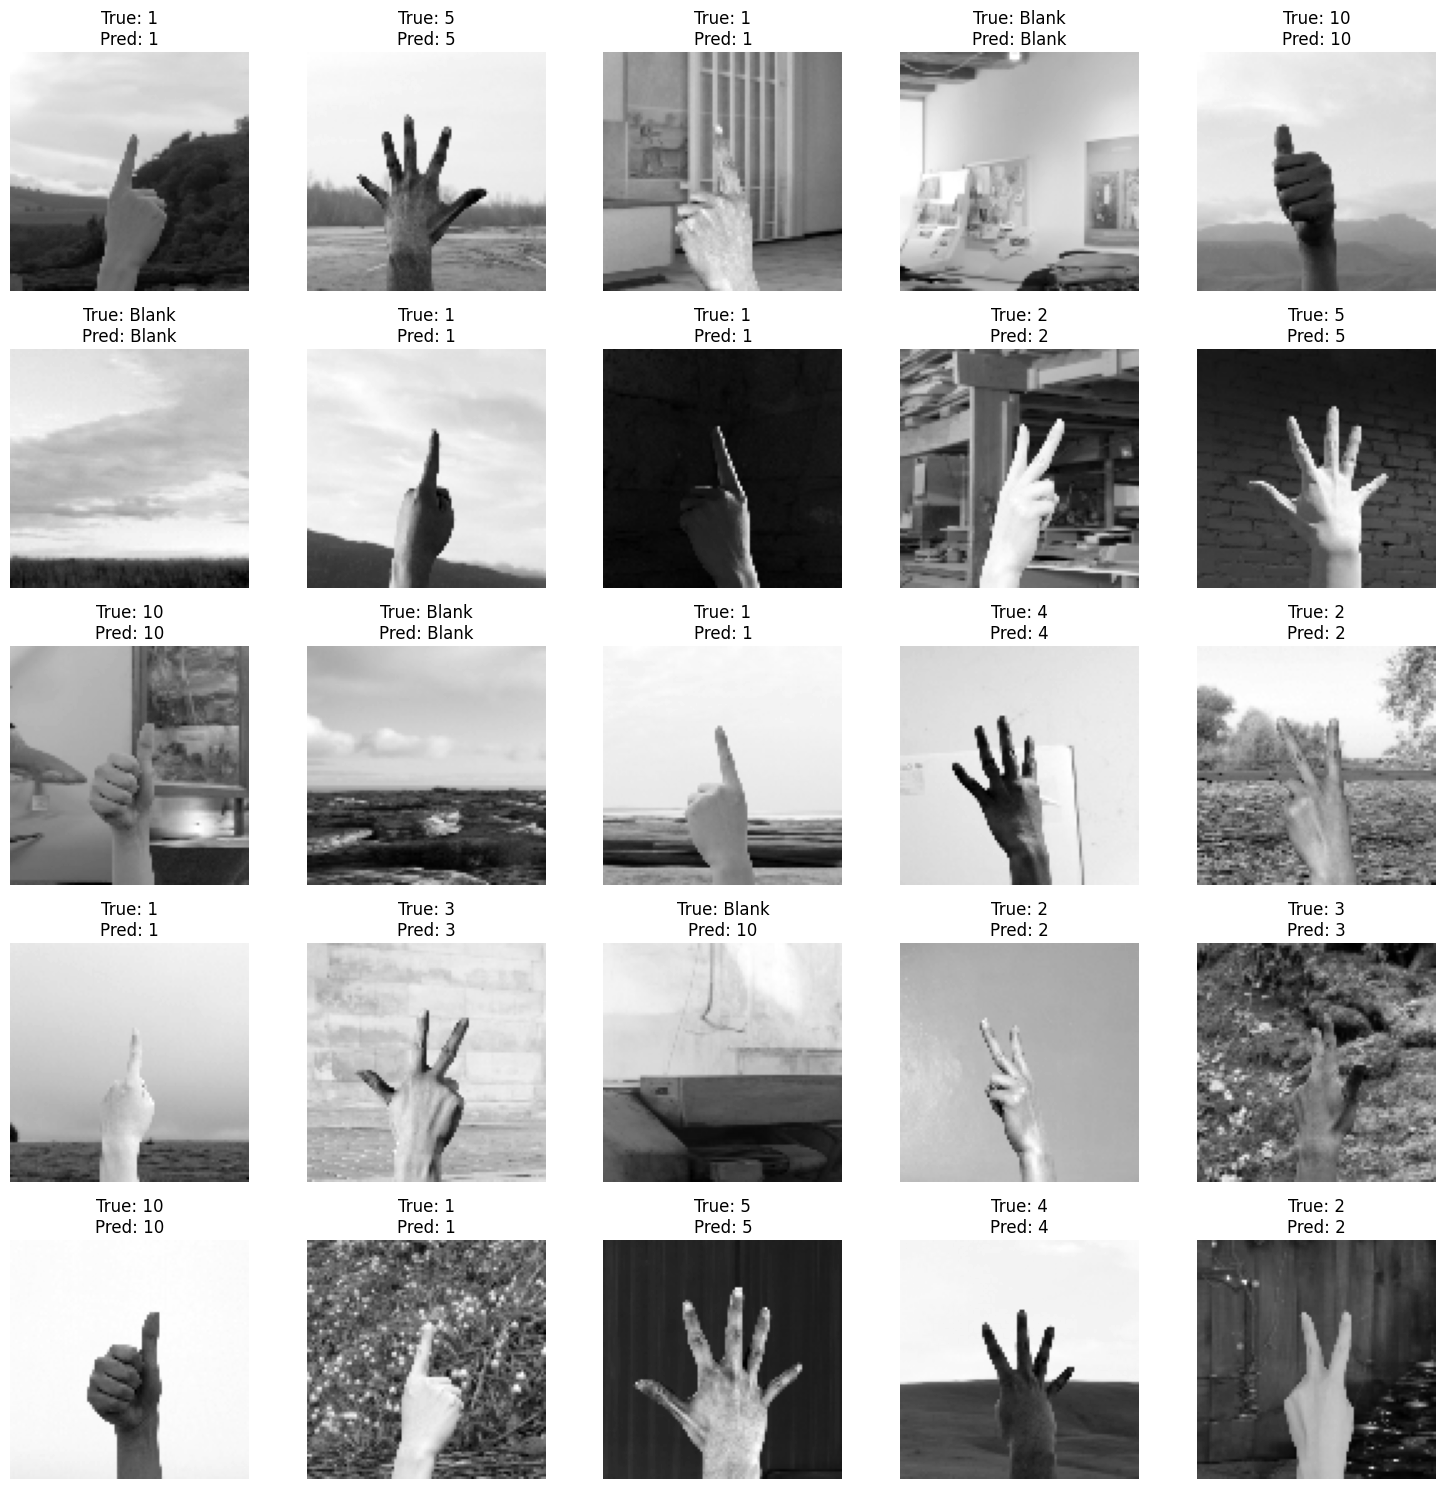

In [40]:
num_images_to_display = 25
plt.figure(figsize=(15, 15))

for i in range(num_images_to_display):
  plt.subplot(5, 5, i + 1)
  plt.imshow(X_test[i].reshape(96, 96), cmap='gray')
  plt.title(f"True: {LIST_OF_GESTURES[y_true_classes[i]]}\nPred: {LIST_OF_GESTURES[y_pred_classes[i]]}")
  plt.axis('off')

plt.tight_layout()
plt.show()

## Precision por clase

In [41]:
interpreter = tf.lite.Interpreter(model_path=QUANTIZED_MODEL_PATH)
interpreter.allocate_tensors()

input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()

def preprocess_image(image):
    image = image.astype(np.uint8)
    image = image.reshape(1, 96, 96, 1)
    return image

def evaluate_model(interpreter, test_images, test_labels):
    total_seen = 0
    num_correct = 0
    class_correct = np.zeros(test_labels.shape[1])
    class_total = np.zeros(test_labels.shape[1])

    for i in range(len(test_images)):
        input_data = preprocess_image(test_images[i])
        interpreter.set_tensor(input_details[0]['index'], input_data)
        interpreter.invoke()
        output_data = interpreter.get_tensor(output_details[0]['index'])
        predicted_label = np.argmax(output_data)
        true_label = np.argmax(test_labels[i])
        if predicted_label == true_label:
            num_correct += 1
            class_correct[true_label] += 1
        class_total[true_label] += 1
        total_seen += 1

    accuracy = num_correct / total_seen
    print(f"Precisión del modelo cuantizado: {accuracy:.4f}")

    for i, (correct, total) in enumerate(zip(class_correct, class_total)):
        if total > 0:
            class_accuracy = correct / total
            print(f"Precisión para clase {i}: {class_accuracy:.4f} (Correctos: {int(correct)}, Total: {int(total)})")
        else: print(f"Clase {i} no tiene ejemplos en el conjunto de prueba.")

evaluate_model(interpreter, X_test, y_test)

model_size = os.path.getsize(QUANTIZED_MODEL_PATH)
print(f"Tamaño del modelo cuantizado: {model_size / 1024:.2f} KB")

Precisión del modelo cuantizado: 0.9664
Precisión para clase 0: 0.9657 (Correctos: 197, Total: 204)
Precisión para clase 1: 0.9894 (Correctos: 186, Total: 188)
Precisión para clase 2: 0.9659 (Correctos: 198, Total: 205)
Precisión para clase 3: 0.9447 (Correctos: 188, Total: 199)
Precisión para clase 4: 0.9663 (Correctos: 172, Total: 178)
Precisión para clase 5: 0.9904 (Correctos: 206, Total: 208)
Precisión para clase 6: 0.9450 (Correctos: 206, Total: 218)
Tamaño del modelo cuantizado: 296.28 KB


# HEXADECIMAL

In [43]:
!xxd -i {QUANTIZED_MODEL_PATH} > {HEX_MODEL_PATH}